<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


## Build a cube

This notebook demonstrates _ITSCube_ class which is used to generate time series of velocity pair granules for the region of interest which is defined by a polygon in target UTM projection.

### ITSCube:
1. Submits a query to the API to get a list of ITS_LIVE granules qualifying to be included into the cube.
   * Polygon UTM coordinates are converted to longitude/latitude coordinates in order for them to be passed to the API search query.
1. Accesses ITS_LIVE granules, which are stored in AWS S3 bucket, remotely without downloading them to the local storage.
1. Filters each ITS_LIVE granule by region of interest, and loads variables data only for the region.

The following logic is followed in qualifying the granule for inclusion into the data cube:
1. Ignores granules that don't contain valid data for the region of interest. It keeps track of a number of such ignored granules.
1. Ignores granules that are defined in other than target UTM projection. It keeps track of a number of such ignored granules.
1. In a case when multiple granules exist for the same middle date (middle date + time displacement as milliseconds), it picks the
   newest processed granule.


### ITSCube TODO
 * Interpolate polygon edges (lat/lon coordinates) to get better region inclusion when submitting granule query to the search API

In [67]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set up Dask diagnostics

In [68]:
# from dask.distributed import Client
# client = Client(processes=True, n_workers=8)
# client

#### Prepare parameters for the cube generation, including ITSLIVE API parameters to search for granules of interest

In [69]:
from itscube import ITSCube

# Create polygon as a square around the centroid in target '32628' UTM projection
# Projection for the polygon coordinates
projection = '32628'

# Centroid for the tile in target projection
c_x, c_y = (487462, 9016243)

# Offset in meters (1 pixel=240m): 100 km square (with offset=50km)
off = 50000 
polygon = ((c_x - off, c_y + off), (c_x + off, c_y + off), (c_x + off, c_y - off), (c_x - off, c_y - off), (c_x - off, c_y + off))
print(f"Polygon in UTM {projection}: {polygon}")

# Create cube object
cube = ITSCube(polygon, projection)

# TODO: Should have them as separate input parameters for ITSCube.create()?
API_params = {
    'start'               : '2010-01-05',
    'end'                 : '2020-01-01',
    'percent_valid_pixels': 1
}

Polygon in UTM 32628: ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))
Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


#### Create cube using remote access to S3 granules

In [71]:
# Examine only first 100 granules - too slow to access S3 bucket locally
found_urls = cube.create(API_params, 100)

Reading and processing S3 granules:   0%|          | 0/100 [00:00<?, ?it/s]

Number of found by API granules: 55498 (took 5.619842242998857 seconds)
Examining only first 100 out of 55498 found granules


Reading and processing S3 granules:   8%|8         | 8/100 [00:03<00:32,  2.80it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20150528_20180130_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P067.nc for existing 2015-05-20 00:00:00.016000 in layers
Replacing data for 2015-05-20 00:00:00.016000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20150528_20180130_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P067.nc


Reading and processing S3 granules:  14%|#4        | 14/100 [00:04<00:26,  3.28it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170728_01_T1_G0240V01_P051.nc for existing 2017-07-28 00:00:00.016000 in layers
Replacing data for 2017-07-28 00:00:00.016000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P051.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170728_01_T1_G0240V01_P051.nc


Reading and processing S3 granules:  56%|#####6    | 56/100 [00:17<00:15,  2.92it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20180418_20180501_01_T1_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc for existing 2017-12-03 00:00:00.272000 in layers
Replacing data for 2017-12-03 00:00:00.272000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20180418_20180419_01_RT_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20180418_20180501_01_T1_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc


Reading and processing S3 granules:  82%|########2 | 82/100 [00:25<00:05,  3.03it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20170729_20170730_01_RT_X_LC08_L1TP_039242_20170627_20170628_01_RT_G0240V01_P045.nc for existing 2017-07-13 00:00:00.032000 in layers
Keeping data for 2017-07-13 00:00:00.032000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20170729_20170811_01_T1_X_LC08_L1TP_039242_20170627_20170714_01_T1_G0240V01_P045.nc instead of new granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20170729_20170730_01_RT_X_LC08_L1TP_039242_20170627_20170628_01_RT_G0240V01_P045.nc


Reading and processing S3 granules:  86%|########6 | 86/100 [00:27<00:04,  3.01it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180417_01_T2_G0240V01_P092.nc for existing 2018-05-05 00:00:00.048000 in layers
Replacing data for 2018-05-05 00:00:00.048000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180411_01_RT_G0240V01_P092.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180417_01_T2_G0240V01_P092.nc


Reading and processing S3 granules:  98%|#########8| 98/100 [00:31<00:00,  3.13it/s]

Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_041242_20170711_20170726_01_T1_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc for existing 2017-01-16 00:00:00.352000 in layers
Replacing data for 2017-01-16 00:00:00.352000: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_041242_20170711_20170712_01_RT_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_041242_20170711_20170726_01_T1_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc


Reading and processing S3 granules: 100%|##########| 100/100 [00:31<00:00,  3.13it/s]


Combining layers by date...
Combined 94 layers by date (took 0.3570761760001915 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)


#### Save cube data to the file and read it back in

In [72]:
cube.to_netcdf('test_cube_100.nc')

In [73]:
import xarray as xr
with xr.open_dataset('test_cube_100.nc', engine="h5netcdf") as ds:
    ds.info()
    ds.coords
#     ds.coords['x'].values[0]
#     ds.coords['y'].values[0]
#     ds.sel(x=437632.5, y=8966287.5)

xarray.Dataset {
dimensions:
	mid_date = 94 ;
	x = 341 ;
	y = 233 ;

variables:
	datetime64[ns] mid_date(mid_date) ;
	object url(mid_date) ;
	float32 v(mid_date, y, x) ;
	float32 vx(mid_date, y, x) ;
	float32 vy(mid_date, y, x) ;
	float64 x(x) ;
		x:long_name = x coordinate of projection ;
		x:standard_name = projection_x_coordinate ;
		x:units = m ;
	float64 y(y) ;
		y:long_name = y coordinate of projection ;
		y:standard_name = projection_y_coordinate ;
		y:units = m ;

// global attributes:
	:GDAL_AREA_OR_POINT = Area ;
	:author = Alex S. Gardner, JPL/NASA ;
	:institution = NASA Jet Propulsion Laboratory (JPL), California Institute of Technology ;
	:projection = 32628 ;
	:title = ITS_LIVE datacube of velocity pairs ;
}

Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2015-08-05T00:00:00.032000 ... 2017-1...
  * x         (x) float64 4.376e+05 4.379e+05 4.381e+05 ... 5.19e+05 5.192e+05
  * y         (y) float64 8.966e+06 8.967e+06 8.967e+06 ... 9.022e+06 9.022e+06

#### Create cube using remote access to S3 granules in parallel

In [74]:
p_cube = ITSCube(polygon, projection)
p_found_urls = p_cube.create_parallel(API_params, 100)

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
Number of found by API granules: 55498 (took 5.643954876000862 seconds)
Examining only first 100 out of 55498 found granules
[########################################] | 100% Completed | 12.7s
Found another granule http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20150528_20180130_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P067.nc for existing 2015-05-20 00:00:00.016000 in layers
Replacing data for 2015-05-20 00:00:00.016000 layer: http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc by http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocit

In [75]:
p_cube.layers.info()

xarray.Dataset {
dimensions:
	mid_date = 94 ;
	x = 341 ;
	y = 233 ;

variables:
	float32 v(mid_date, y, x) ;
	float32 vx(mid_date, y, x) ;
	float32 vy(mid_date, y, x) ;
	<U191 url(mid_date) ;
	datetime64[ns] mid_date(mid_date) ;
	float64 x(x) ;
		x:units = m ;
		x:standard_name = projection_x_coordinate ;
		x:long_name = x coordinate of projection ;
	float64 y(y) ;
		y:units = m ;
		y:standard_name = projection_y_coordinate ;
		y:long_name = y coordinate of projection ;

// global attributes:
	:title = ITS_LIVE datacube of velocity pairs ;
	:author = Alex S. Gardner, JPL/NASA ;
	:institution = NASA Jet Propulsion Laboratory (JPL), California Institute of Technology ;
	:GDAL_AREA_OR_POINT = Area ;
	:projection = 32628 ;
}

#### Verify that the cubes generated sequentially and in parallel are the same

In [76]:
cube.layers.equals(p_cube.layers)

True

### Download granules locally and build the cube accessing local files

#### Invoke the following cell ONLY if granules were not downloaded yet (downloads to default "data" directory)

In [77]:
# from itslive import itslive_ui
# ui = itslive_ui('north')
# files = ui.download_velocity_pairs(found_urls, start=0, end=100)

In [78]:
# len(files)

In [79]:
local_cube = ITSCube(polygon, projection)
found_urls = local_cube.create_from_local_no_api()

Processing local granules:   4%|4         | 4/100 [00:00<00:02, 34.45it/s]

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


Processing local granules:  31%|###1      | 31/100 [00:01<00:02, 29.86it/s]

Found another granule data/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc for existing 2015-05-20 00:00:00.016000 in layers
Keeping data for 2015-05-20 00:00:00.016000 layer: data/LC08_L1TP_008002_20150528_20180130_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P067.nc instead of new granule data/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc


Processing local granules:  38%|###8      | 38/100 [00:01<00:02, 29.72it/s]

Found another granule data/LC08_L1TP_008002_20180418_20180419_01_RT_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc for existing 2017-12-03 00:00:00.272000 in layers
Keeping data for 2017-12-03 00:00:00.272000 layer: data/LC08_L1TP_008002_20180418_20180501_01_T1_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc instead of new granule data/LC08_L1TP_008002_20180418_20180419_01_RT_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc


Processing local granules:  57%|#####6    | 57/100 [00:01<00:01, 27.97it/s]

Found another granule data/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170728_01_T1_G0240V01_P051.nc for existing 2017-07-28 00:00:00.016000 in layers
Replacing data for 2017-07-28 00:00:00.016000 layer: data/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P051.nc by data/LC08_L1TP_008002_20170805_20170812_01_T1_X_LC08_L1TP_008002_20170720_20170728_01_T1_G0240V01_P051.nc


Processing local granules:  70%|#######   | 70/100 [00:02<00:00, 30.08it/s]

Found another granule data/LC08_L1TP_039242_20170729_20170730_01_RT_X_LC08_L1TP_039242_20170627_20170628_01_RT_G0240V01_P045.nc for existing 2017-07-13 00:00:00.032000 in layers
Keeping data for 2017-07-13 00:00:00.032000 layer: data/LC08_L1TP_039242_20170729_20170811_01_T1_X_LC08_L1TP_039242_20170627_20170714_01_T1_G0240V01_P045.nc instead of new granule data/LC08_L1TP_039242_20170729_20170730_01_RT_X_LC08_L1TP_039242_20170627_20170628_01_RT_G0240V01_P045.nc


Processing local granules:  82%|########2 | 82/100 [00:02<00:00, 29.27it/s]

Found another granule data/LC08_L1TP_041242_20170711_20170712_01_RT_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc for existing 2017-01-16 00:00:00.352000 in layers
Keeping data for 2017-01-16 00:00:00.352000 layer: data/LC08_L1TP_041242_20170711_20170726_01_T1_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc instead of new granule data/LC08_L1TP_041242_20170711_20170712_01_RT_X_LC08_L1TP_041242_20160724_20170222_01_T1_G0240V01_P060.nc


Processing local granules: 100%|##########| 100/100 [00:03<00:00, 29.28it/s]


Found another granule data/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180411_01_RT_G0240V01_P092.nc for existing 2018-05-05 00:00:00.048000 in layers
Keeping data for 2018-05-05 00:00:00.048000 layer: data/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180417_01_T2_G0240V01_P092.nc instead of new granule data/LC08_L1TP_039242_20180529_20180605_01_T2_X_LC08_L1TP_039242_20180411_20180411_01_RT_G0240V01_P092.nc
Combining layers by date...
Combined 94 layers by date (took 0.39774007800042455 seconds)
Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)


#### Read local files in parallel using Dask

In [80]:
parallel_cube = ITSCube(polygon, projection)
found_urls = parallel_cube.create_from_local_parallel_no_api()

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
[########################################] | 100% Completed |  2.8s
Found another granule data/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc for existing 2015-05-20 00:00:00.016000 in layers
Keeping data for 2015-05-20 00:00:00.016000 layer: data/LC08_L1TP_008002_20150528_20180130_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P067.nc instead of new granule data/LC08_L1TP_008002_20150528_20170408_01_T2_X_LC08_L1TP_008002_20150512_20170409_01_T1_G0240V01_P066.nc
Found another granule data/LC08_L1TP_008002_20180418_20180419_01_RT_X_LC08_L1TP_008002_20170720_20170720_01_RT_G0240V01_P042.nc for existing 2017-12-03 00:00:00.272000 in layers
Keeping data for 2017-12-03 00:00:00.272000 layer: da

### Display data of cube layers

#### Display first 10 of cube layers

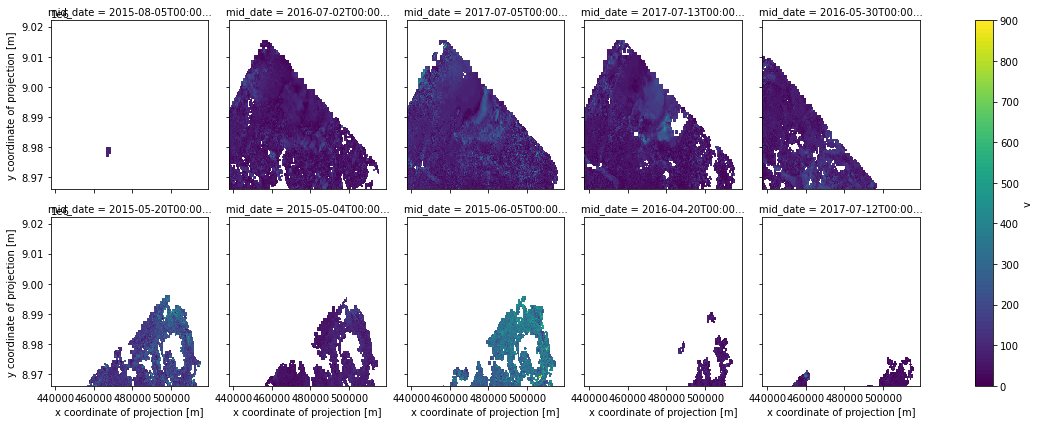

In [86]:
cube.plot('v', (0, 10))

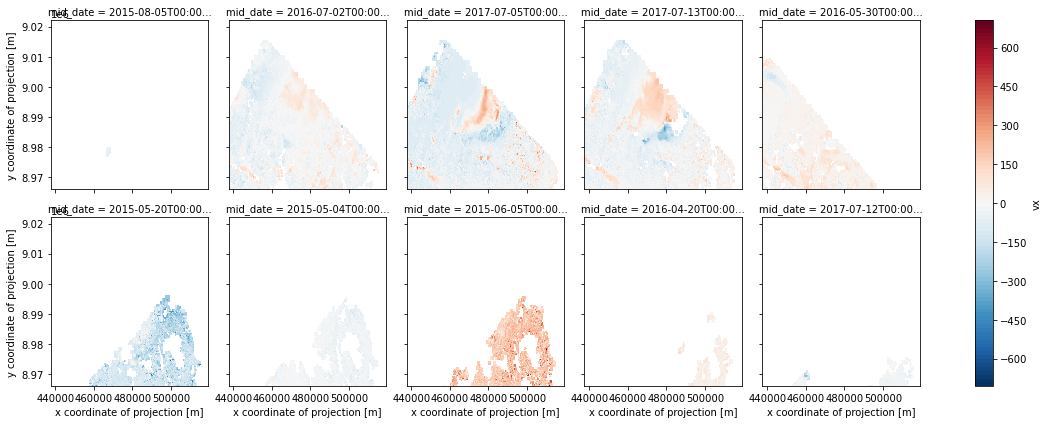

In [83]:
cube.plot('vx', (0, 10))

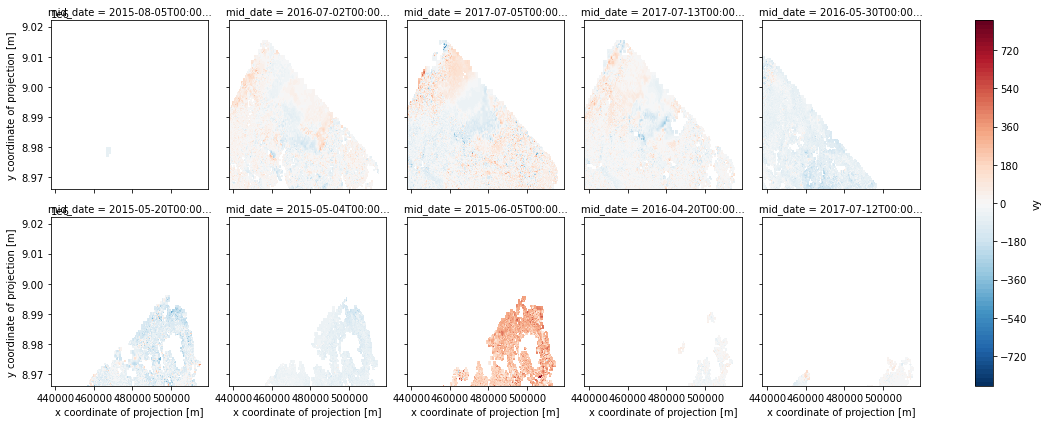

In [84]:
cube.plot('vy', (0, 10))

#### Display layers [40:50] of the cube

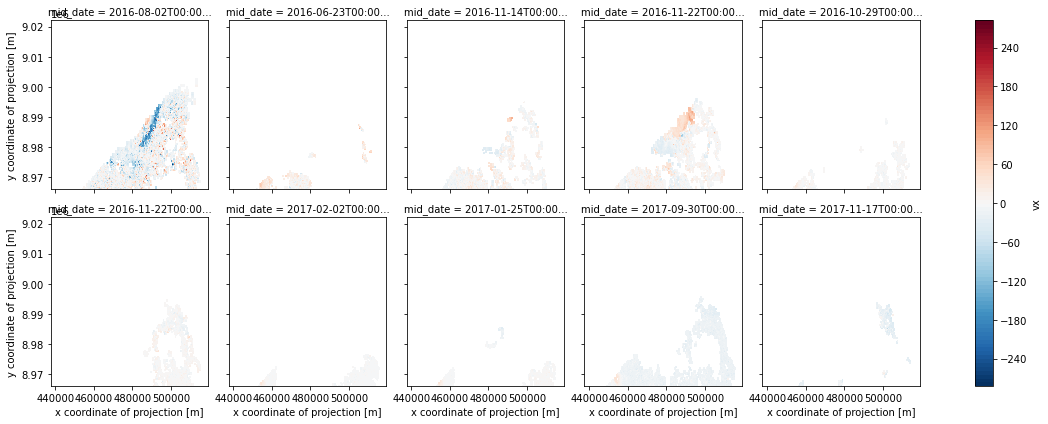

In [85]:
cube.plot('vx', (40, 50))